In [8]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd

In [55]:
df = pd.read_csv('notnice.csv')

In [56]:
df.head()

,x,y
0,-0.500000,0.635972
1,-0.467742,-1.492855
2,-0.435484,-3.640599
3,-0.403226,-4.953248
4,-0.370968,-6.815221


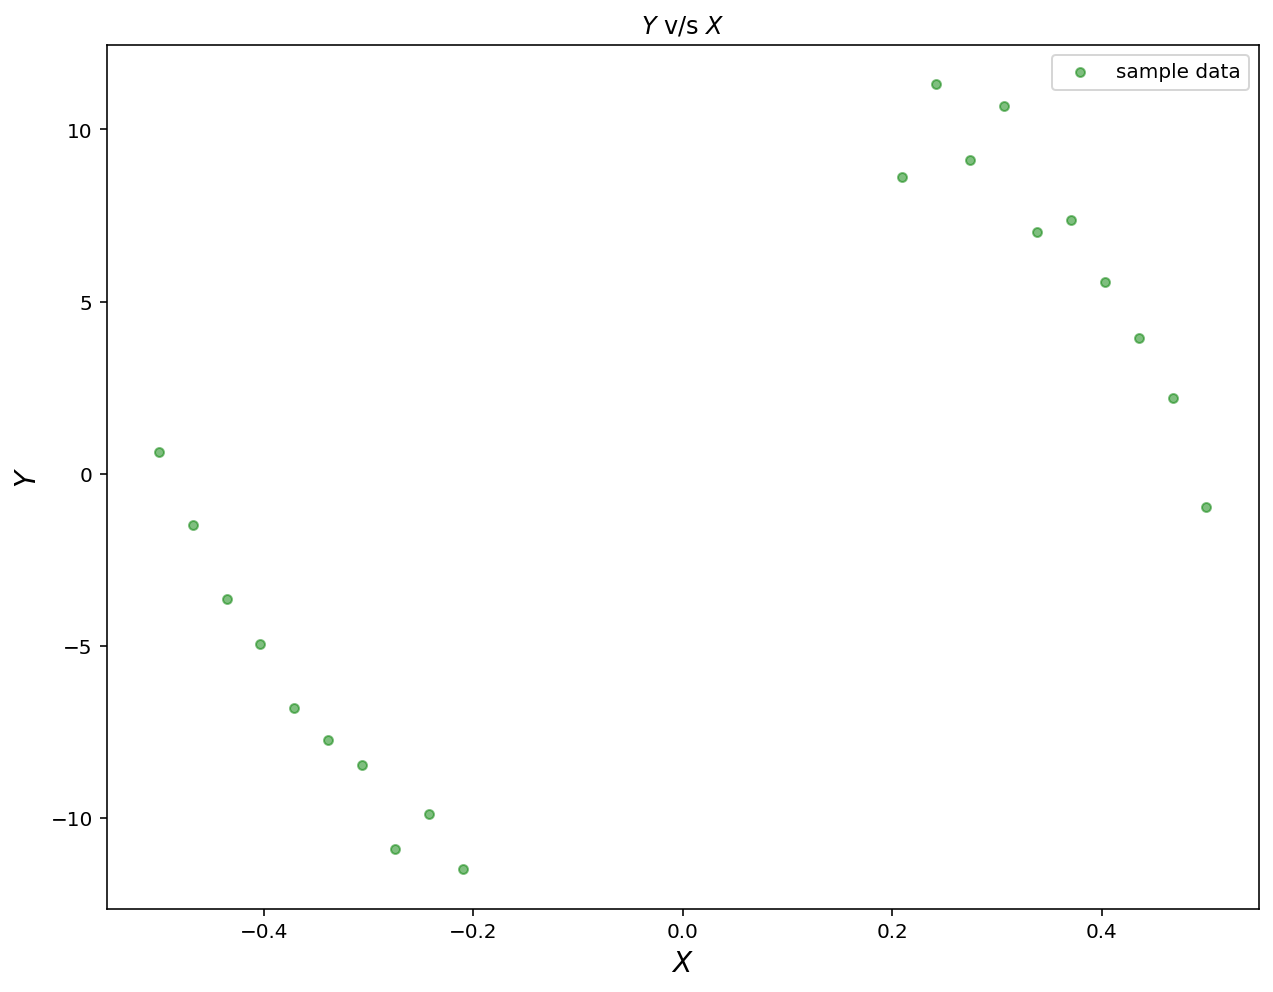

In [57]:
X_data = df.iloc[:,0]
y_data = df.iloc[:,1]
plt.figure(figsize=(4,6))
plt.scatter(X_data, y_data,color='g' , s=20,alpha = 0.5, label='sample data')
plt.title('$Y$ v/s $X$'); 
plt.xlabel('$X$',fontsize=14); 
plt.ylabel('$Y$',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

In [58]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

In [59]:
import tensorflow as tf

In [60]:
a = tf.convert_to_tensor(5,dtype='int32')

In [61]:
x = tf.convert_to_tensor(X_data, dtype=dtype)
x = tf.reshape(x,(-1,1))
y = tf.convert_to_tensor(y_data, dtype=dtype)
y = tf.reshape(y, (-1, 1))

# Imports

In [62]:
from tensorflow.keras import backend as K # Need to check if this can be avoided
from tensorflow.keras.layers import Layer # Some abstraction to add weights
import tensorflow as tf

# Get functional API, and optimizer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [63]:
# Refer to segment 3.4 equation (8)
train_size = x.shape[0]  
noise = 1.0
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

In [64]:
# Below block of code is just to define some nice functions to get the trainable variables ready

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.exp(1.)-1)
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [65]:
# We're using Dense Variational layers
# Unlike regular dense layers, these take posteriors (q(w/0))
# and priors P(w)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=1,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight)
],name='BayesbyBackprop')

In [66]:
model.summary()

Model: "BayesbyBackprop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_9 (DenseVa (None, 20)                120       
_________________________________________________________________
dense_variational_10 (DenseV (None, 20)                1260      
_________________________________________________________________
dense_variational_11 (DenseV (None, 1)                 63        
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________


In [67]:
# This is just a simple loss function
# Taking the negative log likelihood
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

In [68]:
model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.03), metrics=['mse'])
model.fit(x, y, batch_size=batch_size, epochs=3000, verbose=0);

In [69]:
import tqdm

In [70]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []
for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    

100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


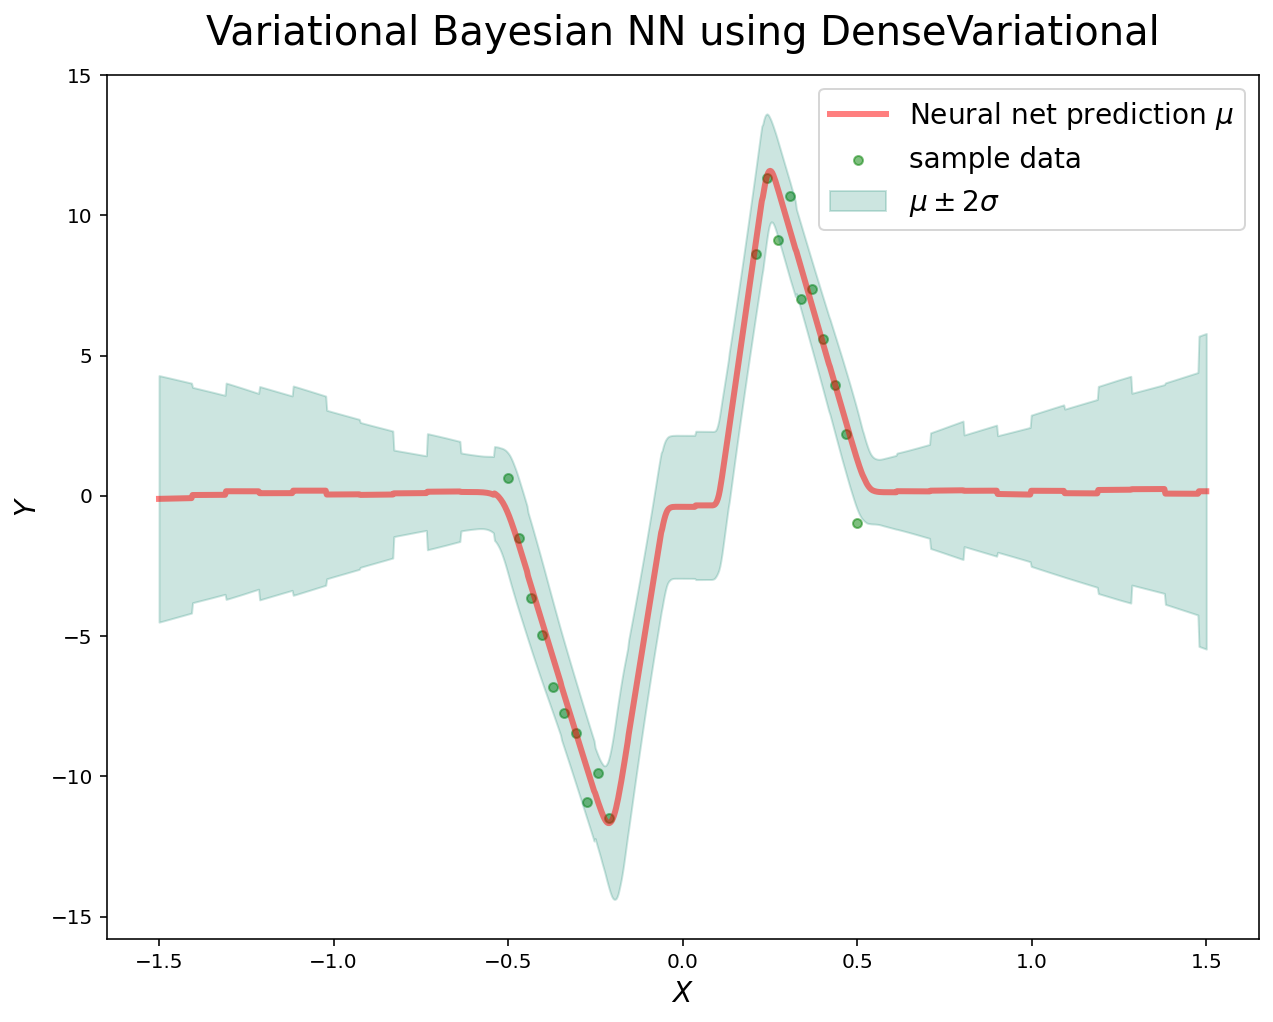

In [71]:
plt.figure(figsize=(4,6))
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)
plt.scatter(X_data, y_data,color='g' , s=20,alpha = 0.5, label='sample data')
plt.plot(X_test, y_mean,color='r',lw=3, alpha = 0.5, label='Neural net prediction $\mu$')
plt.fill_between(X_test.ravel(), y_mean+2*y_sigma, y_mean-2*y_sigma, color="#007D66", \
                alpha=0.2,label = '$\mu \pm 2\sigma$')
plt.title('Variational Bayesian NN using DenseVariational',fontsize=20,y=1.02); 
plt.xlabel('$X$',fontsize=14); 
plt.ylabel('$Y$',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend(fontsize=14)
plt.show()

In [72]:
# Time to flipout
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseFlipout(20,activation='relu'),
    tfp.layers.DenseFlipout(units=20,
                                activation='relu'),
    tfp.layers.DenseFlipout(units=1)
])

/Users/hargunoberoi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_3 (DenseFlipou (None, 20)                60        
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 20)                820       
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 1)                 41        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.03), metrics=['mse'])
model.fit(x, y, batch_size=batch_size, epochs=3000, verbose=0);

In [75]:
X_test = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)
y_pred_list = []
for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    

100%|██████████| 500/500 [00:15<00:00, 32.22it/s]


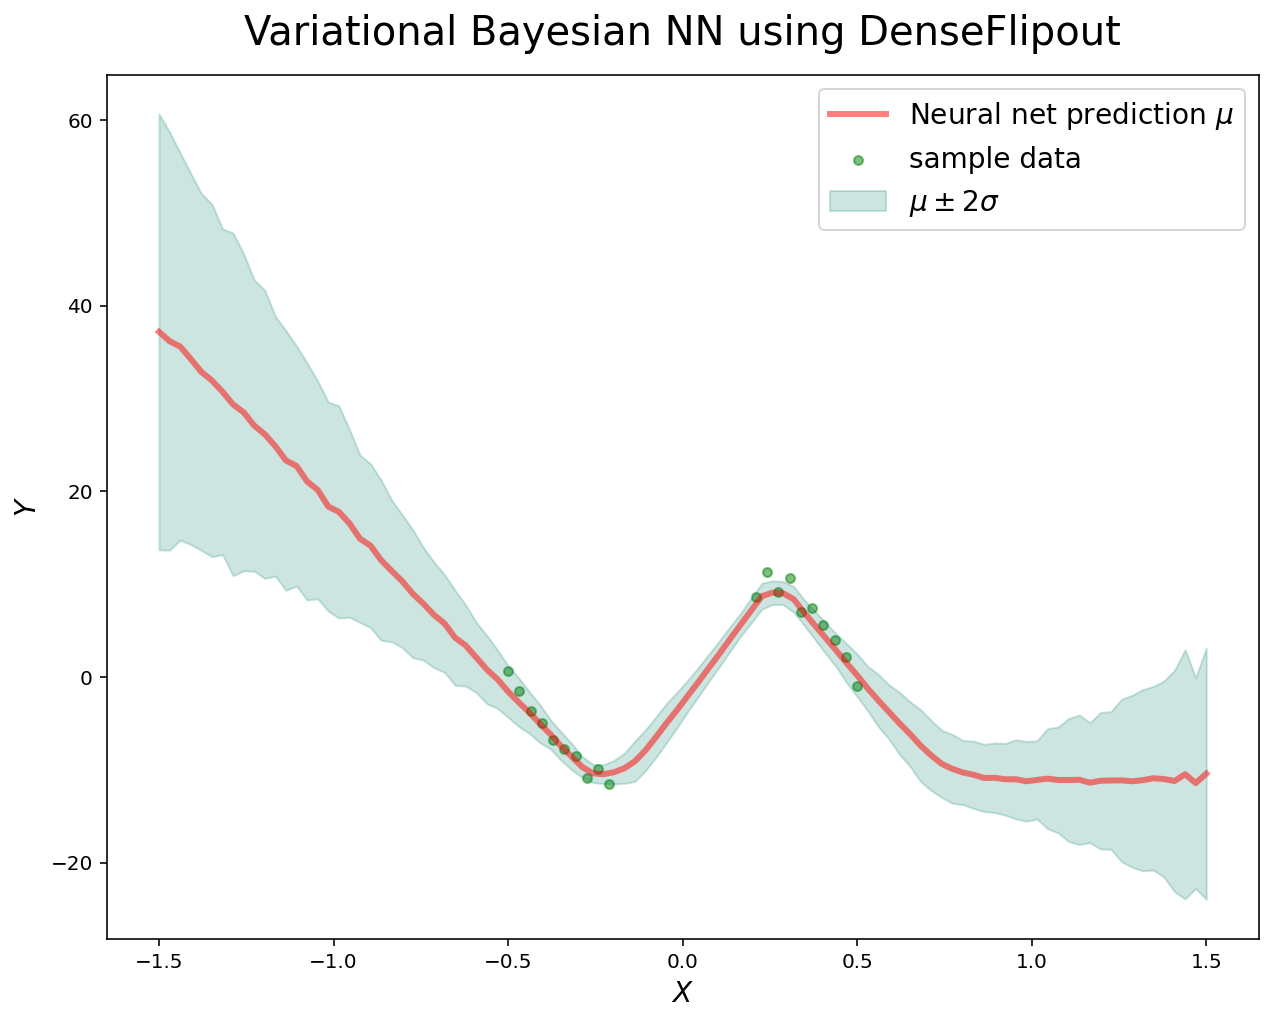

In [76]:
plt.figure(figsize=(4,6))
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)
plt.scatter(X_data, y_data,color='g' , s=20,alpha = 0.5, label='sample data')
plt.plot(X_test, y_mean,color='r',lw=3, alpha = 0.5, label='Neural net prediction $\mu$')
plt.fill_between(X_test.ravel(), y_mean+2*y_sigma, y_mean-2*y_sigma, color="#007D66", \
                alpha=0.2,label = '$\mu \pm 2\sigma$')
plt.title('Variational Bayesian NN using DenseFlipout',fontsize=20,y=1.02); 
plt.xlabel('$X$',fontsize=14); 
plt.ylabel('$Y$',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend(fontsize=14)
plt.show()

## Questions:

1. What is mean field?
- Something to do with the weights
2. What is `tfp.layers.VariableLayer`?
- Just makes variables
3. What is `softplus`? 
- Some RELU variant
4. What's the difference between `tfd.Normal` & `tfd.distributions.Normal`?

## Notes:

1. We assume that the weights are **not** correlated